# Differential Diagnosis of COVID-19 with Bayesian Belief Networks

Let's see if a Bayesian Belief Network (`BBN`) is able to diagnose the COVID-19 virus with any reasonable success. The idea is that a patients presents some symptoms, and we must diagnostically reason from the `symptoms` back to the `cause`. The `BBN` is taken from [BayesiaLab's](https://www.bayesia.com/) [Differential Diagnosis](https://forum.bayesia.us/t/83hhnxy/covid-19-websimulator-for-differential-diagnosis) model.

## Data

The data is taken from the [Hubei dataset](https://github.com/beoutbreakprepared/nCoV2019/tree/master/covid19/raw-data). We will first load both sets of data.

In [1]:
import pandas as pd

inside = pd.read_csv('./covid/data/00/COVID19_2020_open_line_list - Hubei.csv', low_memory=False)
outside = pd.read_csv('./covid/data/00/COVID19_2020_open_line_list - outside_Hubei.csv', low_memory=False)

outside = outside.drop(['data_moderator_initials'], axis=1)

data = pd.concat([inside, outside])

## Data Transformation

We will apply transformations to the data, primarily on the symptoms. There are only about 200 unique symptoms on all the COVID-19 patients. We map these 200 unique symptoms in a many-to-many approach to 32 broad symptom categories. The following are the 32 broad symptom categories.

* abdominal_pain
* anorexia
* anosmia
* chest
* chills
* coronary
* diarrhoea
* digestive
* discharge
* dizziness
* dry_cough
* dryness
* dyspnea
* eye
* fatigue
* fever
* headache
* lungs
* malaise
* mild
* muscle
* myelofibrosis
* nasal
* nausea
* respiratory
* running_nose
* sneezing
* sore_throat
* sputum
* sweating
* walking
* wheezing

In [2]:
import json
import itertools
from datetime import datetime

with open('./covid/data/00/symptom-mapping.json', 'r') as f:
    symptom_map = json.load(f)

def tokenize(s):
    if s is None or isinstance(s, float) or len(s) < 1 or pd.isna(s):
        return None
    try:
        delim = ';' if ';' in s else ','
        return [t.strip().lower() for t in s.split(delim) if len(t.strip()) > 0]
    except:
        return s

def map_to_symptoms(s):
    if s.startswith('fever') or s.startswith('low fever'):
        return ['fever']
    return [k for k, v in symptom_map.items() if s in v]
    

d = data[['symptoms']].dropna(how='all').copy(deep=True)
print(d.shape)

d.symptoms = d.symptoms.apply(lambda s: tokenize(s))
d.symptoms = d.symptoms.apply(lambda tokens: [map_to_symptoms(s) for s in tokens] if tokens is not None else None)
d.symptoms = d.symptoms.apply(lambda arrs: None if arrs is None else list(itertools.chain(*arrs)))

for s in symptom_map.keys():
    d[s] = d.symptoms.apply(lambda arr: 0 if arr is None else 1 if s in arr else 0)

d = d.drop(['symptoms'], axis=1)
print(d.shape)

(656, 1)
(656, 32)


In [3]:
d.describe()

,anosmia,sputum,muscle,chills,fever,wheezing,nasal,fatigue,headache,sore_throat,...,eye,walking,discharge,dizziness,dryness,digestive,coronary,mild,myelofibrosis,sweating
count,656.0,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,...,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000,656.000000
mean,0.0,0.035061,0.082317,0.036585,0.721037,0.001524,0.012195,0.085366,0.042683,0.089939,...,0.001524,0.001524,0.001524,0.004573,0.009146,0.001524,0.001524,0.024390,0.001524,0.001524
std,0.0,0.184074,0.275057,0.187885,0.448832,0.039043,0.109840,0.279639,0.202296,0.286313,...,0.039043,0.039043,0.039043,0.067522,0.095271,0.039043,0.039043,0.154375,0.039043,0.039043
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
d.dtypes

anosmia           int64
sputum            int64
muscle            int64
chills            int64
fever             int64
wheezing          int64
nasal             int64
fatigue           int64
headache          int64
sore_throat       int64
dry_cough         int64
diarrhoea         int64
dyspnea           int64
nausea            int64
sneezing          int64
running_nose      int64
abdominal_pain    int64
respiratory       int64
lungs             int64
malaise           int64
anorexia          int64
chest             int64
eye               int64
walking           int64
discharge         int64
dizziness         int64
dryness           int64
digestive         int64
coronary          int64
mild              int64
myelofibrosis     int64
sweating          int64
dtype: object

In [5]:
%%time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# takes too long to render

# plt.style.use('seaborn')

# n_cols = 2
# n_rows = int(d.shape[1] / n_cols)

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))
# axes = np.ravel(axes)

# for ax, c in zip(axes, d.columns):
#     s = d[c]
#     s.plot(kind='bar', ax=ax, title=f'{c}')

# plt.tight_layout()

CPU times: user 82.1 ms, sys: 15.1 ms, total: 97.2 ms
Wall time: 97.4 ms


## Bayesian Belief Network

The BBN structure is a result of assuming independence between the symptoms, and we know this assumption is wrong. However, we know that if we do not assume independence between the symptoms, there are more parameters to estimate and/or provide. As for the parameters, according to the original authors of this BBN, the parameters are taken from a variety of sources. 

The following are the variables (or nodes) in the BBN.

* anosmia
* chills
* diarrhoea
* dry_cough
* dyspnea
* fatigue
* fever
* headache
* muscle
* nasal
* nausea
* running_nose
* sneezing
* sore_throat
* sputum
* wheezing

Note that all these nodes, except `disease` and `flu_shot` are symptoms. 

### BBN structure

In [6]:
from pybbn.graph.dag import Bbn
from pybbn.pptc.inferencecontroller import InferenceController
import json

with open('./covid/naive.json', 'r') as f:
    bbn = Bbn.from_dict(json.load(f))
join_tree = InferenceController.apply(bbn)

The following shows the BBN structure. The `disease` node points to all the symptoms, and the `flu_shot` node points to the `disease` node. The `disease` node has the following values/states.

* no_virus
* rhinovirus
* hmpv (Metapneumovirus)
* hrsv (Respiratory syncytial)
* influenza
* covid19 (COVID-19)

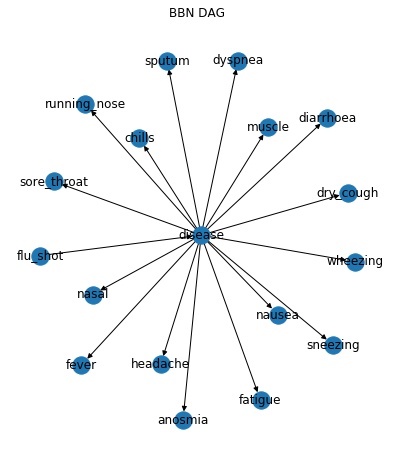

In [7]:
from pybbn.generator.bbngenerator import convert_for_drawing
import networkx as nx
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    graph = convert_for_drawing(bbn)
    pos = nx.nx_agraph.graphviz_layout(graph, prog='neato')

    plt.figure(figsize=(15, 8))
    plt.subplot(121) 
    labels = dict([(k, node.variable.name) for k, node in bbn.nodes.items()])
    nx.draw(graph, pos=pos, with_labels=True, labels=labels)
    plt.title('BBN DAG')

### BBN Parameters

The following shows the marginal posteriors of the nodes.

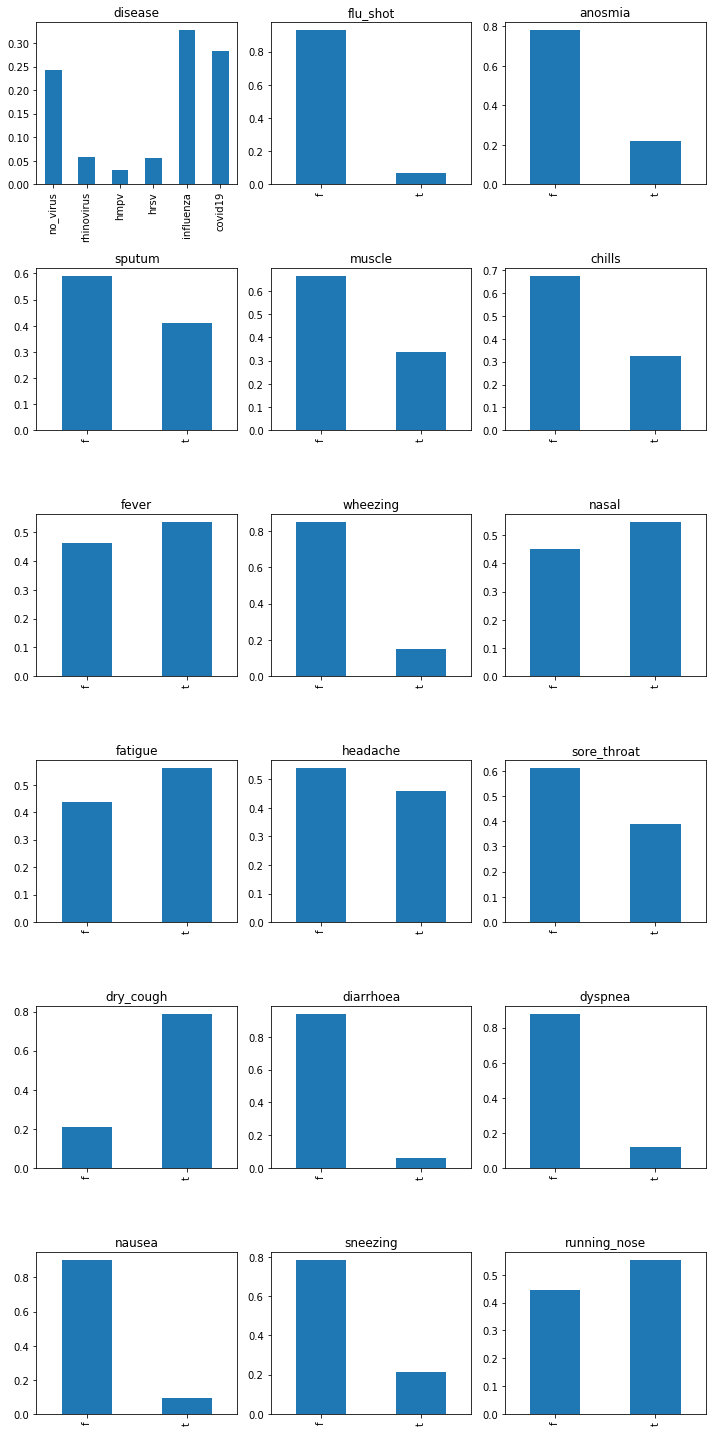

In [8]:
def potential_to_series(potential):
    def get_entry_kv(entry):
        arr = [(k, v) for k, v in entry.entries.items()]
        arr = sorted(arr, key=lambda tup: tup[0])
        return arr[0][1], entry.value
    
    tups = [get_entry_kv(e) for e in potential.entries]
    return pd.Series([tup[1] for tup in tups], [tup[0] for tup in tups])
    
series = [(node, potential_to_series(join_tree.get_bbn_potential(node))) for node in join_tree.get_bbn_nodes()]

n_cols = 3
n_rows = int(len(series) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 20))
axes = np.ravel(axes)

for ax, (node, s) in zip(axes, series):
    s.plot(kind='bar', ax=ax, title=f'{node.variable.name}')

plt.tight_layout()

## Diagnosis

Now we are ready to make diagnosis using the BBN. The total set of symptoms in the Hubei dataset (as we have transformed them) is 32, however, there are only 16 symptoms modeled into the BBN.

In [9]:
%%time

from pybbn.graph.jointree import EvidenceBuilder

names = [
    'anosmia', 'sputum', 'muscle', 'chills', 'fever', 
    'wheezing', 'nasal', 'fatigue', 'headache', 'sore_throat',
    'dry_cough', 'diarrhoea', 'dyspnea', 'nausea', 'sneezing',
    'running_nose'
]

predictions = []

for i, r in d.iterrows():
    fields = [name for name in names if r[name] == 1]
    
    join_tree.unobserve_all()
    
    if len(fields) > 0:
        bbn_nodes = [join_tree.get_bbn_node_by_name(f) for f in fields]
        evidences = [EvidenceBuilder().with_node(n).with_evidence('t', 1.0).build() for n in bbn_nodes]
        join_tree.update_evidences(evidences)
    
    disease = join_tree.get_bbn_node_by_name('disease')
    disease_potential = join_tree.get_bbn_potential(disease)
    s = potential_to_series(disease_potential)
    
    predictions.append(s)

CPU times: user 6.74 s, sys: 25.4 ms, total: 6.77 s
Wall time: 6.79 s


In [10]:
predictions = pd.DataFrame(predictions)
predictions

,no_virus,rhinovirus,hmpv,hrsv,influenza,covid19
0,0.021350,0.011572,0.040865,0.058689,0.465734,0.401790
1,0.194664,0.056940,0.028707,0.085324,0.197598,0.436766
2,0.010166,0.013346,0.032700,0.040446,0.838125,0.065217
3,0.000525,0.017707,0.047804,0.135938,0.748414,0.049613
4,0.194664,0.056940,0.028707,0.085324,0.197598,0.436766
...,...,...,...,...,...,...
651,0.001141,0.020118,0.034012,0.069237,0.875403,0.000089
652,0.242781,0.058875,0.031008,0.055796,0.327462,0.284078
653,0.242781,0.058875,0.031008,0.055796,0.327462,0.284078
654,0.021350,0.011572,0.040865,0.058689,0.465734,0.401790


## Diagnosis Performance

All the records/patients in the Hubei dataset are positively-tested COVID-19 patients. Thus, we have no non-COVID-19 patients, and so we will avoid using performance measures that requires negative examples. 

### Improper scoring rules

We will try using [average precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) and plot the [precision recall curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html). Note the absurdity of doing so. These performance measures are so-called `quasi-proper scoring rules`.

In [11]:
from sklearn.metrics import average_precision_score

y_true = np.ones(predictions.shape[0])
y_pred = predictions.covid19

ap = average_precision_score(y_true, y_pred)
print(f'average precision score is {ap:.5f}')

average precision score is 1.00000


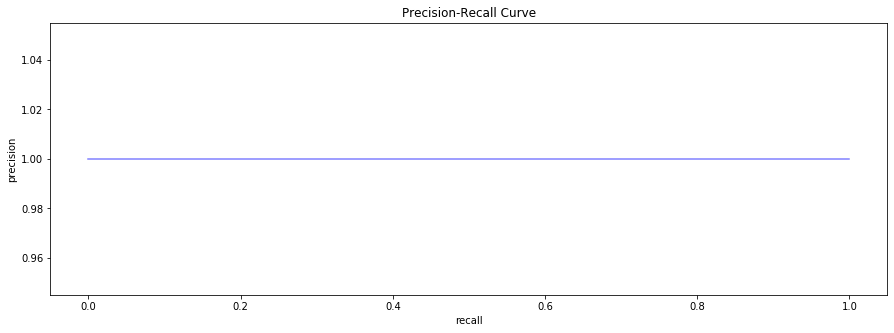

In [12]:
from sklearn.metrics import precision_recall_curve

pre, rec, _ = precision_recall_curve(y_true, y_pred)

fig, ax = plt.subplots(figsize=(15, 5))

_ = ax.step(rec, pre, color='b', alpha=0.5, where='post', label='PR curve')
_ = ax.set_xlabel('recall')
_ = ax.set_ylabel('precision')
_ = ax.set_title('Precision-Recall Curve')

### Proper scoring rule

Instead, we use a `proper scoring rule` such as the [Brier loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html#sklearn.metrics.brier_score_loss). The Brier score is in the range $[0, 1]$, where a value closer to 0 is better. The Brier score essentially is the mean squared difference between the real probability and predicted one. As you can see, the Brier score is about 0.49. Is this value good or bad? It is right smack in the middle; meaning, it is not un-useful, but could be. 

In [13]:
from sklearn.metrics import brier_score_loss

bsl = brier_score_loss(y_true, y_pred)
print(f'brier score loss = {bsl:.5f}')

brier score loss = 0.48920


## Misc

Ignore the code below. It will print out all the unique symptoms in the Hubei data. Useful for the symptom mapping exercise.

In [14]:
# x = [tokenize(s) for s in data.symptoms if s is not None]
# x = [tokens for tokens in x if tokens is not None and len(tokens) > 0]
# n = len(x)
# x = list(itertools.chain(*[item for item in x]))
# for i, s in enumerate(sorted(list(set(x)))):
#     print(f'{i}, {s}')